# Installing graphtool

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -q graph-tool

# Imports


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import networkx as nx
import graph_tool.all as gt
import seaborn as sns
from collections import Counter, defaultdict


# Load and convert graphtool networks into networkx

In [ ]:
# Load the networks
school_ids = ['1','2','6','11_1', '11_2', '11_3', '11_4', '11_5','11_6','11_7','11_8','11_9','11_10']
nws = []
for i in school_ids:
    g = gt.collection.ns[f"spanish_highschools/{i}"]
    nws.append(g)

In [ ]:
#Convert gt to nx
def gt_to_nx(gt_graph, school_id):
    """Convert graph-tool graph to NetworkX with proper handling of weights and attributes"""
    # Create NetworkX graph (directed since friendship networks are directed)
    G = nx.DiGraph()

    # Add nodes with attributes
    for v in gt_graph.vertices():
        node_attrs = {}
        for prop_name in gt_graph.vertex_properties:
            prop = gt_graph.vertex_properties[prop_name]
            try:
                if prop.value_type() == 'string':
                    node_attrs[prop_name] = prop[v]
                else:
                    node_attrs[prop_name] = float(prop[v])
            except:
                pass
        G.add_node(int(v), **node_attrs)

    # Add edges with weights
    for e in gt_graph.edges():
        source, target = int(e.source()), int(e.target())
        weight = 1  # default weight

        # Try to get edge weight if available
        if 'weight' in gt_graph.edge_properties:
            weight = gt_graph.edge_properties['weight'][e]
        elif 'friendship' in gt_graph.edge_properties:
            weight = gt_graph.edge_properties['friendship'][e]

        G.add_edge(source, target, weight=weight)

    # Store school identifier
    G.graph['school_id'] = school_id
    return G

In [ ]:
nx_networks = []
for i, gt_graph in enumerate(nws):
    nx_graph = gt_to_nx(gt_graph, school_ids[i])
    # Convert to undirected for structural analysis (friendship is typically mutual)
    nx_graph_undirected = nx_graph.to_undirected()
    nx_networks.append(nx_graph_undirected)

print(f"Loaded {len(nx_networks)} school networks")
for i, G in enumerate(nx_networks):
    print(f"School {school_ids[i]}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Loaded 13 school networks
School 1: 409 nodes, 6509 edges
School 2: 238 nodes, 2889 edges
School 6: 534 nodes, 9527 edges
School 11_1: 291 nodes, 4255 edges
School 11_2: 702 nodes, 9365 edges
School 11_3: 195 nodes, 3172 edges
School 11_4: 121 nodes, 1176 edges
School 11_5: 246 nodes, 3075 edges
School 11_6: 145 nodes, 1881 edges
School 11_7: 105 nodes, 1081 edges
School 11_8: 378 nodes, 2584 edges
School 11_9: 515 nodes, 5027 edges
School 11_10: 458 nodes, 5866 edges


#  1. K-CORE DECOMPOSITION ANALYSIS

In [ ]:
def analyze_k_cores(networks, school_ids):
    """Comprehensive k-core analysis for all networks"""
    k_core_results = {}

    for i, G in enumerate(networks):
        school_id = school_ids[i]

        # Compute k-core decomposition
        core_numbers = nx.core_number(G)

        # Get k-core subgraphs for different k values
        max_core = max(core_numbers.values()) if core_numbers else 0
        k_cores = {}

        for k in range(1, max_core + 1):
            k_core_nodes = [node for node, core_num in core_numbers.items() if core_num >= k]
            if k_core_nodes:
                k_cores[k] = G.subgraph(k_core_nodes).copy()

        # Core distribution
        core_dist = Counter(core_numbers.values())

        k_core_results[school_id] = {
            'core_numbers': core_numbers,
            'k_cores': k_cores,
            'max_core': max_core,
            'core_distribution': core_dist,
            'nodes_in_max_core': len([n for n, c in core_numbers.items() if c == max_core])
        }

    return k_core_results

In [ ]:
def visualize_k_cores(networks, k_core_results, school_ids):
    """Visualize k-core analysis results"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Core number distribution across schools
    ax1 = axes[0, 0]
    school_names = []
    max_cores = []
    avg_cores = []

    for school_id in school_ids:
        if school_id in k_core_results:
            result = k_core_results[school_id]
            school_names.append(f"School {school_id}")
            max_cores.append(result['max_core'])
            avg_cores.append(np.mean(list(result['core_numbers'].values())))

    x = np.arange(len(school_names))
    width = 0.35

    ax1.bar(x - width/2, max_cores, width, label='Max Core Number', alpha=0.8)
    ax1.bar(x + width/2, avg_cores, width, label='Average Core Number', alpha=0.8)
    ax1.set_xlabel('Schools')
    ax1.set_ylabel('Core Number')
    ax1.set_title('K-Core Analysis: Maximum and Average Core Numbers')
    ax1.set_xticks(x)
    ax1.set_xticklabels(school_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Core size distribution for a representative school
    ax2 = axes[0, 1]
    # Choose school with highest max core for detailed analysis
    representative_school = max(k_core_results.keys(),
                              key=lambda x: k_core_results[x]['max_core'])
    rep_result = k_core_results[representative_school]

    k_values = list(rep_result['k_cores'].keys())
    core_sizes = [rep_result['k_cores'][k].number_of_nodes() for k in k_values]

    ax2.plot(k_values, core_sizes, 'o-', linewidth=2, markersize=8)
    ax2.set_xlabel('K-Core Level')
    ax2.set_ylabel('Number of Nodes')
    ax2.set_title(f'Core Hierarchy - School {representative_school}')
    ax2.grid(True, alpha=0.3)

    # 3. Nodes in maximum core vs network size
    ax3 = axes[1, 0]
    network_sizes = [G.number_of_nodes() for G in networks]
    max_core_sizes = [k_core_results[school_ids[i]]['nodes_in_max_core']
                     for i in range(len(school_ids)) if school_ids[i] in k_core_results]

    ax3.scatter(network_sizes, max_core_sizes, alpha=0.7, s=60)
    ax3.set_xlabel('Network Size (Total Nodes)')
    ax3.set_ylabel('Nodes in Maximum Core')
    ax3.set_title('Core Size vs Network Size')
    ax3.grid(True, alpha=0.3)

    # Add correlation coefficient
    if len(network_sizes) == len(max_core_sizes):
        corr = np.corrcoef(network_sizes, max_core_sizes)[0, 1]
        ax3.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax3.transAxes,
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    # 4. Network visualization of k-cores for representative school
    ax4 = axes[1, 1]
    G_rep = networks[school_ids.index(representative_school)]
    pos = nx.spring_layout(G_rep, k=1, iterations=50)

    # Color nodes by core number
    core_numbers = rep_result['core_numbers']
    node_colors = [core_numbers.get(node, 0) for node in G_rep.nodes()]

    nodes = nx.draw_networkx_nodes(G_rep, pos, node_color=node_colors,
                                  node_size=30, cmap=plt.cm.viridis, ax=ax4)
    nx.draw_networkx_edges(G_rep, pos, alpha=0.3, width=0.5, ax=ax4)

    ax4.set_title(f'K-Core Visualization - School {representative_school}')
    ax4.axis('off')

    # Add colorbar
    plt.colorbar(nodes, ax=ax4, label='Core Number')

    plt.tight_layout()
    plt.show()

# 2. CLIQUE ANALYSIS

In [ ]:
def analyze_cliques(networks, school_ids, max_clique_size=6):
    """Comprehensive clique analysis"""
    clique_results = {}

    for i, G in enumerate(networks):
        school_id = school_ids[i]

        # Find all maximal cliques
        all_cliques = list(nx.find_cliques(G))

        # Clique size distribution
        clique_sizes = [len(clique) for clique in all_cliques]
        size_distribution = Counter(clique_sizes)

        # Largest cliques
        max_clique_size_found = max(clique_sizes) if clique_sizes else 0
        largest_cliques = [clique for clique in all_cliques
                          if len(clique) == max_clique_size_found]

        # Clique overlap analysis
        node_clique_membership = defaultdict(int)
        for clique in all_cliques:
            for node in clique:
                node_clique_membership[node] += 1

        # Average clique membership
        avg_clique_membership = np.mean(list(node_clique_membership.values())) if node_clique_membership else 0

        clique_results[school_id] = {
            'all_cliques': all_cliques,
            'clique_sizes': clique_sizes,
            'size_distribution': size_distribution,
            'max_clique_size': max_clique_size_found,
            'largest_cliques': largest_cliques,
            'total_cliques': len(all_cliques),
            'node_clique_membership': dict(node_clique_membership),
            'avg_clique_membership': avg_clique_membership
        }

    return clique_results

In [ ]:
def visualize_cliques(networks, clique_results, school_ids):
    """Visualize clique analysis results"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Clique size distribution across schools
    ax1 = axes[0, 0]
    all_sizes = []
    school_labels = []

    for school_id in school_ids[:6]:  # Show first 6 schools for clarity
        if school_id in clique_results:
            sizes = clique_results[school_id]['clique_sizes']
            all_sizes.extend(sizes)
            school_labels.extend([f'School {school_id}'] * len(sizes))

    if all_sizes:
        df = pd.DataFrame({'Clique Size': all_sizes, 'School': school_labels})
        sns.boxplot(data=df, x='School', y='Clique Size', ax=ax1)
        ax1.set_title('Clique Size Distribution Across Schools')
        ax1.tick_params(axis='x', rotation=45)

    # 2. Maximum clique size vs network characteristics
    ax2 = axes[0, 1]
    network_sizes = []
    max_clique_sizes = []
    densities = []

    for i, school_id in enumerate(school_ids):
        if school_id in clique_results and i < len(networks):
            G = networks[i]
            network_sizes.append(G.number_of_nodes())
            max_clique_sizes.append(clique_results[school_id]['max_clique_size'])
            densities.append(nx.density(G))

    scatter = ax2.scatter(network_sizes, max_clique_sizes, c=densities,
                         s=60, alpha=0.7, cmap='viridis')
    ax2.set_xlabel('Network Size')
    ax2.set_ylabel('Maximum Clique Size')
    ax2.set_title('Max Clique Size vs Network Characteristics')
    plt.colorbar(scatter, ax=ax2, label='Network Density')
    ax2.grid(True, alpha=0.3)

    # 3. Clique membership distribution
    ax3 = axes[1, 0]
    # Choose school with most interesting clique structure
    representative_school = max(clique_results.keys(),
                              key=lambda x: clique_results[x]['max_clique_size'])

    membership_counts = list(clique_results[representative_school]['node_clique_membership'].values())
    ax3.hist(membership_counts, bins=max(membership_counts) if membership_counts else 1,
             alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Number of Cliques per Node')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'Clique Membership Distribution - School {representative_school}')
    ax3.grid(True, alpha=0.3)

    # 4. Network visualization with largest clique highlighted
    ax4 = axes[1, 1]
    G_rep = networks[school_ids.index(representative_school)]
    pos = nx.spring_layout(G_rep, k=1, iterations=50)

    # Get largest clique
    largest_clique = clique_results[representative_school]['largest_cliques'][0]

    # Color nodes: clique members vs others
    node_colors = ['red' if node in largest_clique else 'lightblue'
                   for node in G_rep.nodes()]

    nx.draw_networkx_nodes(G_rep, pos, node_color=node_colors,
                          node_size=30, ax=ax4)
    nx.draw_networkx_edges(G_rep, pos, alpha=0.3, width=0.5, ax=ax4)

    # Highlight clique edges
    clique_edges = [(u, v) for u in largest_clique for v in largest_clique
                    if u != v and G_rep.has_edge(u, v)]
    nx.draw_networkx_edges(G_rep, pos, edgelist=clique_edges,
                          edge_color='red', width=2, ax=ax4)

    ax4.set_title(f'Largest Clique (Size {len(largest_clique)}) - School {representative_school}')
    ax4.axis('off')

    plt.tight_layout()
    plt.show()

# SUMMARY ANALYSIS AND INSIGHTS

In [ ]:
def generate_summary_analysis(networks, k_core_results, clique_results, n_clique_results, school_ids):
    """Generate comprehensive summary of structural analysis"""
    summary = {
        'network_overview': {},
        'k_core_insights': {},
        'clique_insights': {},
        'n_clique_insights': {},
        'comparative_analysis': {}
    }

    # Network overview
    for i, school_id in enumerate(school_ids):
        if i < len(networks):
            G = networks[i]
            summary['network_overview'][school_id] = {
                'nodes': G.number_of_nodes(),
                'edges': G.number_of_edges(),
                'density': nx.density(G),
                'avg_clustering': nx.average_clustering(G)
            }

    # K-core insights
    max_core_school = max(k_core_results.keys(), key=lambda x: k_core_results[x]['max_core'])
    summary['k_core_insights'] = {
        'highest_core_school': max_core_school,
        'highest_core_value': k_core_results[max_core_school]['max_core'],
        'avg_max_core': np.mean([result['max_core'] for result in k_core_results.values()]),
        'core_diversity': np.std([result['max_core'] for result in k_core_results.values()])
    }

    # Clique insights
    max_clique_school = max(clique_results.keys(), key=lambda x: clique_results[x]['max_clique_size'])
    summary['clique_insights'] = {
        'largest_clique_school': max_clique_school,
        'largest_clique_size': clique_results[max_clique_school]['max_clique_size'],
        'avg_max_clique_size': np.mean([result['max_clique_size'] for result in clique_results.values()]),
        'total_cliques_range': (min([result['total_cliques'] for result in clique_results.values()]),
                               max([result['total_cliques'] for result in clique_results.values()]))
    }

    return summary

In [ ]:
print("Starting comprehensive structural analysis...")

# Perform all analyses
print("\n1. Analyzing K-cores...")

k_core_results = analyze_k_cores(nx_networks, school_ids)

print("\n2. Analyzing Cliques...")
clique_results = analyze_cliques(nx_networks, school_ids)


Starting comprehensive structural analysis...

1. Analyzing K-cores...

2. Analyzing Cliques...

3. Analyzing N-cliques...


# Generate Visualizations

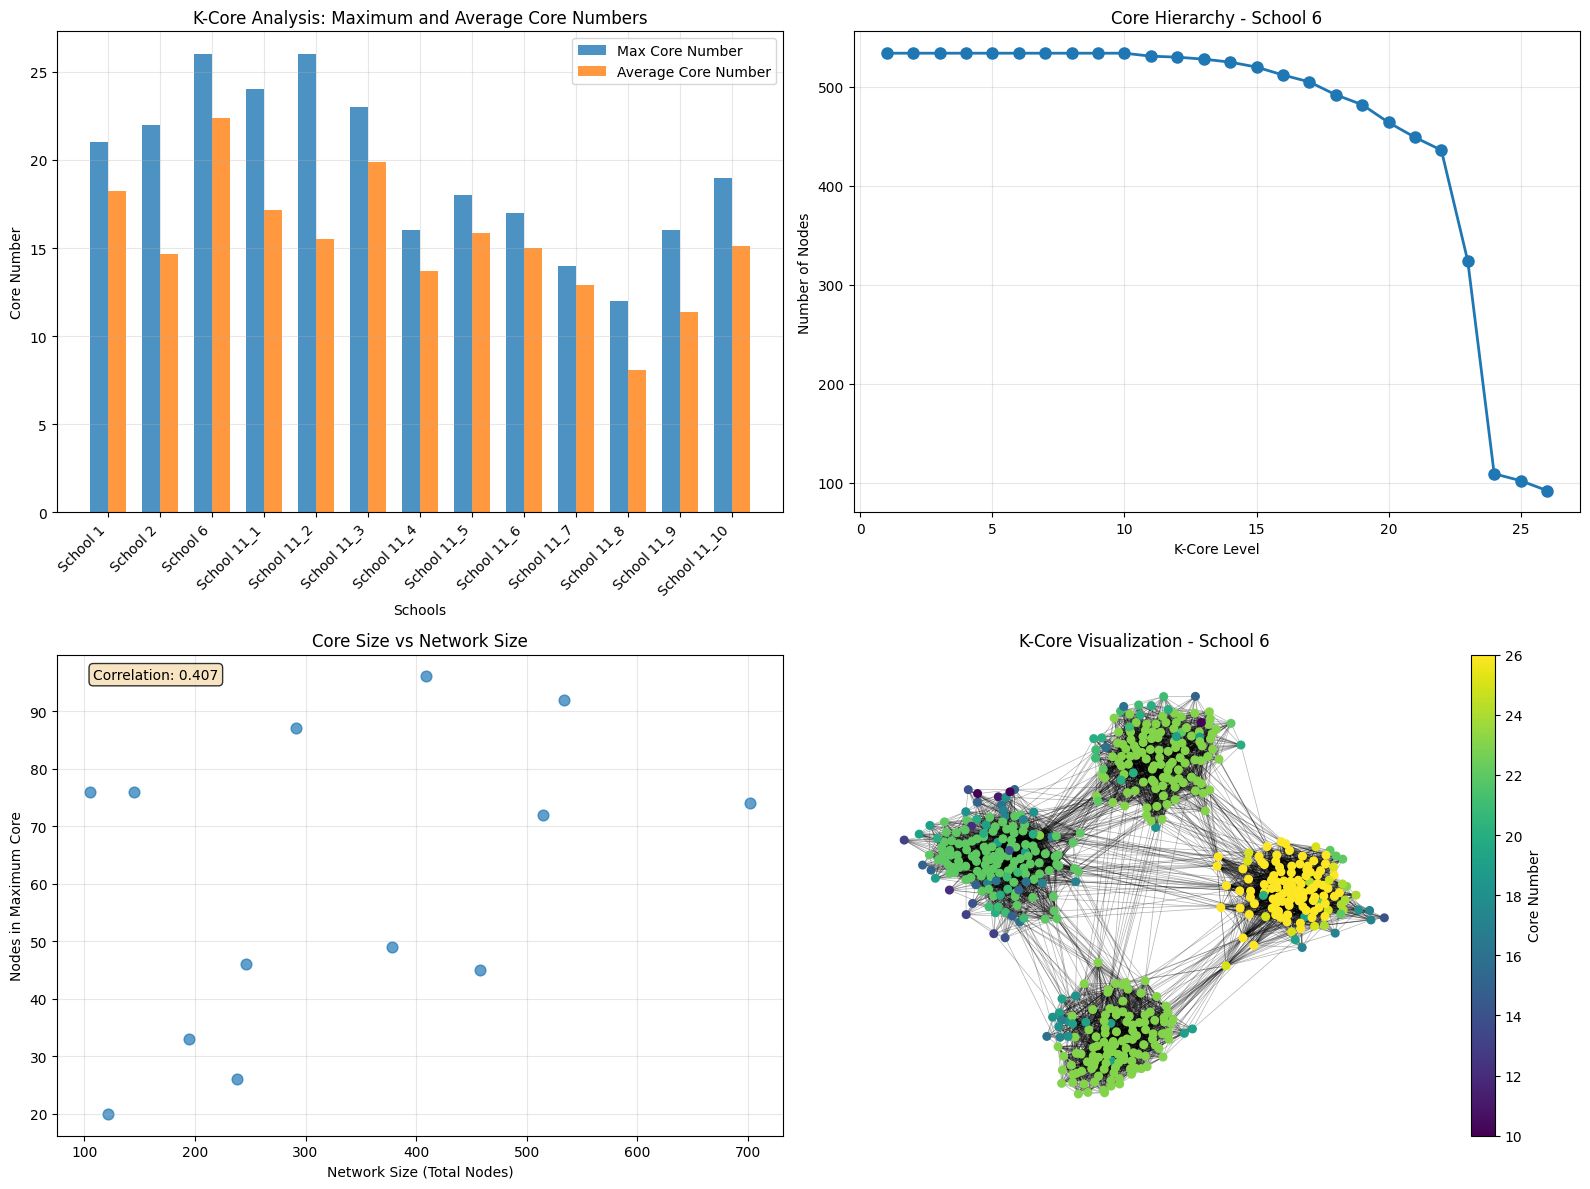

In [ ]:
visualize_k_cores(nx_networks, k_core_results, school_ids)

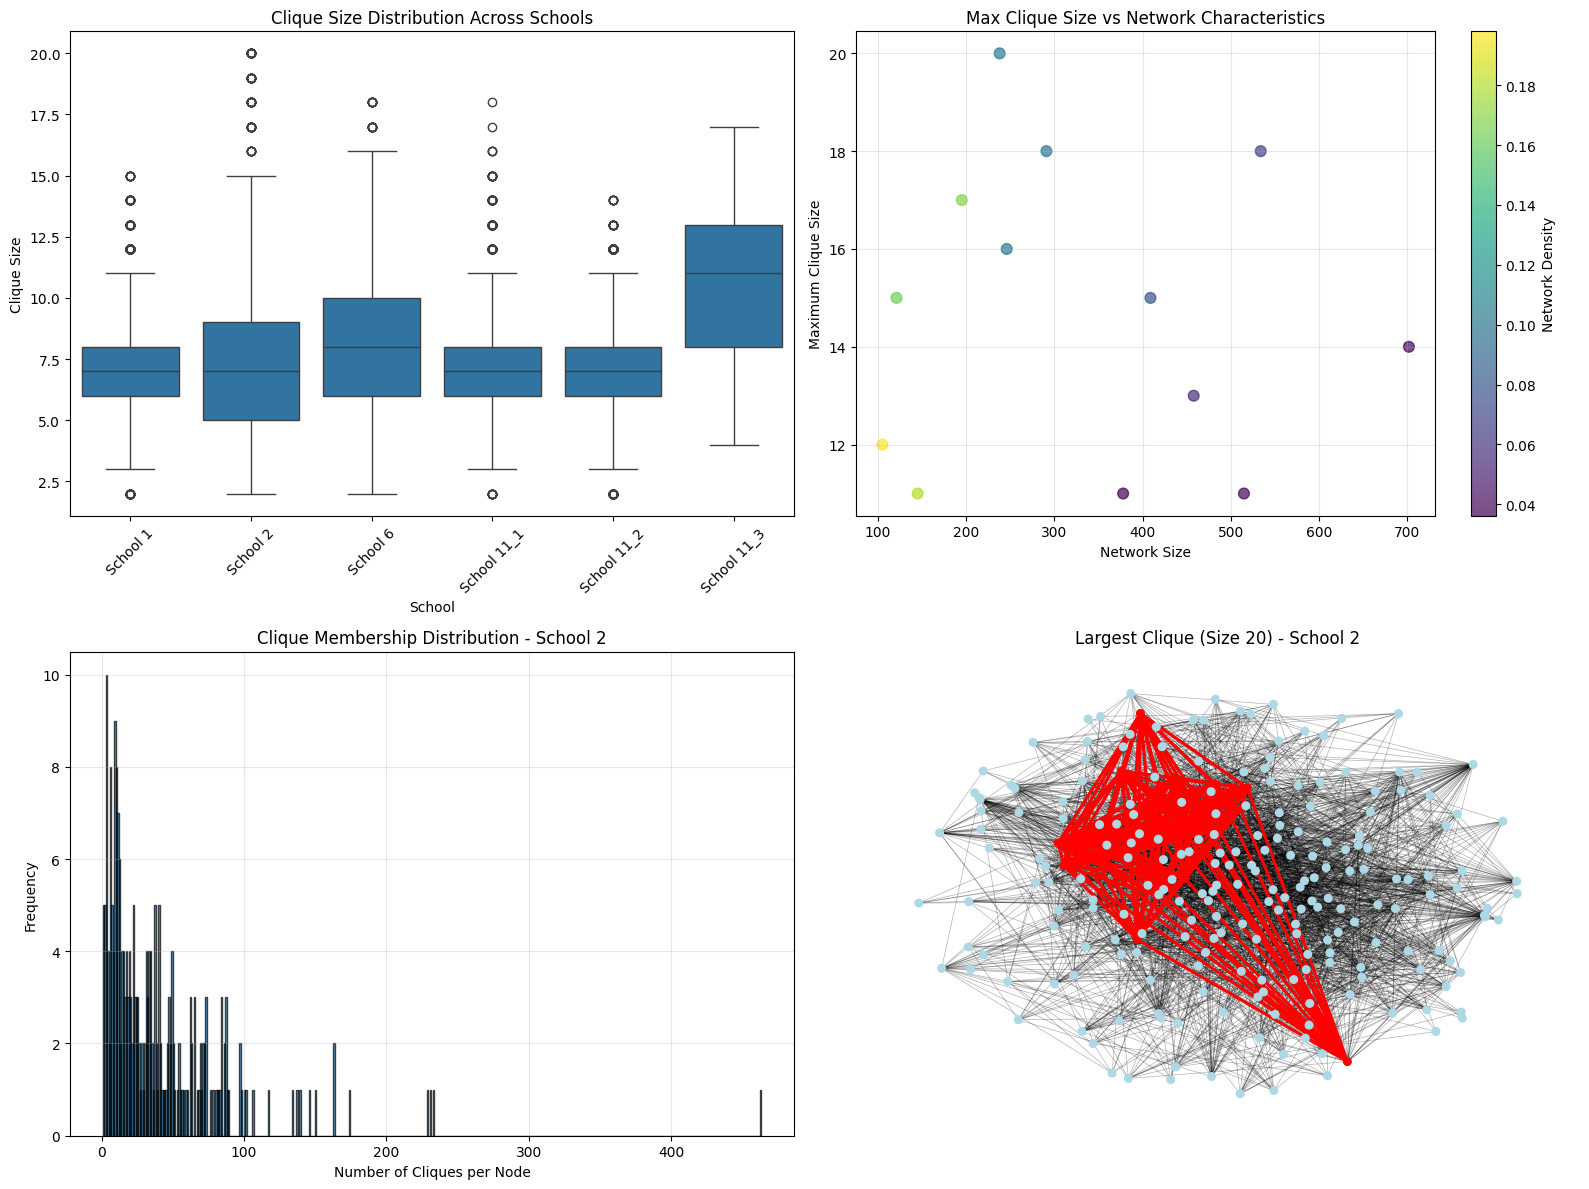

In [ ]:
visualize_cliques(nx_networks, clique_results, school_ids)

In [ ]:
print("\n5. Generating summary analysis...")
summary = generate_summary_analysis(nx_networks, k_core_results, clique_results, n_clique_results, school_ids)

# Print key findings
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)

print(f"\nK-CORE ANALYSIS:")
print(f"• School with highest core: {summary['k_core_insights']['highest_core_school']} (k={summary['k_core_insights']['highest_core_value']})")
print(f"• Average maximum core across schools: {summary['k_core_insights']['avg_max_core']:.2f}")

print(f"\nCLIQUE ANALYSIS:")
print(f"• School with largest clique: {summary['clique_insights']['largest_clique_school']} (size={summary['clique_insights']['largest_clique_size']})")
print(f"• Average maximum clique size: {summary['clique_insights']['avg_max_clique_size']:.2f}")

print(f"\nNETWORK COMPARISON:")
for school_id in school_ids[:5]:  # Show first 5
    if school_id in summary['network_overview']:
        info = summary['network_overview'][school_id]
        print(f"• School {school_id}: {info['nodes']} nodes, density={info['density']:.3f}")

print("\n" + "="*60)
print("Analysis complete! Check the visualizations above for detailed insights.")


5. Generating summary analysis...

KEY FINDINGS SUMMARY

K-CORE ANALYSIS:
• School with highest core: 6 (k=26)
• Average maximum core across schools: 19.54

CLIQUE ANALYSIS:
• School with largest clique: 2 (size=20)
• Average maximum clique size: 14.69

NETWORK COMPARISON:
• School 1: 409 nodes, density=0.078
• School 2: 238 nodes, density=0.102
• School 6: 534 nodes, density=0.067
• School 11_1: 291 nodes, density=0.101
• School 11_2: 702 nodes, density=0.038

Analysis complete! Check the visualizations above for detailed insights.
